In [36]:
# !pip install vaderSentiment
# !pip install bertopic
# !pip install pyvis
# !pip install python-louvain
# !pip install ace_tools
# !pip install pyLDAvis

In [37]:
import pandas as pd
import numpy as np
import json
import re
import scipy.stats as stats
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import seaborn as sns
import spacy
import community.community_louvain as community_louvain
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from hdbscan import HDBSCAN
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from umap import UMAP
from pyvis.network import Network

#Data Processing & Cleaning

In [38]:
with open("InvestmentClub_submissions_refined.json", "r", encoding="utf-8") as file:
  data = json.load(file)

df_sub = pd.DataFrame(data)
print(len(df_sub))

with open("InvestmentClub_comments_refined.json", "r", encoding="utf-8") as file:
    data2 = json.load(file)

df_com = pd.DataFrame(data2)
print(len(df_com))

df_com["unique_parent_id"] = df_com["parent_id"].str.replace("t3_", "").str.replace("t1_", "")

def filter_relevant_columns(df):
    keep_columns = {
        "unique_parent_id", "parent_id", "id", "created_utc", "subreddit", "author", "retrieved_on",
        "ups", "downs", "score", "total_awards_received", "num_comments", "upvote_ratio", "num_reports", "view_count",
        "title", "selftext", "body", "url", "domain",
        "removed_by_category", "removal_reason", "banned_by", "quarantined", "locked",
        "author_premium", "author_cakeday", "author_created_utc",
        "is_self", "spoiler", "over_18",
        "subreddit_type", "link_flair_text", "category",
    }

    filter_df = df[[col for col in keep_columns if col in df.columns]]
    return filter_df

filter_com=filter_relevant_columns(df_com)
filter_sub=filter_relevant_columns(df_sub)

new_df = filter_com[filter_com['unique_parent_id'].isin(filter_sub['id'])]
new_df = new_df.merge(filter_sub[['id', 'title']], left_on='unique_parent_id', right_on='id', how='left')

new_df=new_df.drop(columns=['id_x'])
new_df=new_df.drop(columns=['id_y'])

new_df['author_created_utc'] = pd.to_datetime(new_df['author_created_utc'])
new_df['created_utc'] = pd.to_datetime(new_df['created_utc'], unit='s', errors='coerce')

new_df.shape
new_df.to_csv("new_df.csv", index=False)

18971
22863


In [39]:
new_df

created_utc  ups quarantined subreddit_type author_cakeday  \
0     2012-02-01 18:13:16    2         NaN            NaN            NaN   
1     2012-02-01 19:14:11    1         NaN            NaN            NaN   
2     2012-02-01 19:51:56    2         NaN            NaN            NaN   
3     2012-02-01 20:20:24    1         NaN            NaN            NaN   
4     2012-02-01 20:51:01    3         NaN            NaN            NaN   
...                   ...  ...         ...            ...            ...   
14037 2022-12-31 20:25:52    2       False         public           True   
14038 2022-12-31 21:37:40    2       False         public           True   
14039 2022-12-31 22:16:22    2       False         public           True   
14040 2022-12-31 22:24:49    2       False         public           True   
14041 2022-12-31 23:23:27    2       False         public           True   

       banned_by  score unique_parent_id  \
0            NaN      2            p6dut   
1            NaN      1            p6dut   
2            NaN      2            p6jm5   
3            NaN      1            p6fpo   
4            NaN      3            p6ll4   
...          ...    ...              ...   
14037        NaN      1           zwlyan   
14038        NaN      1           zwd9iw   
14039        NaN      1           z3igew   
14040        NaN      1          10053am   
14041        NaN      2          1000s3h   

                                                    body  removal_reason  ...  \
0                          I think this is a great idea!             NaN  ...   
1      Which simulator are you going to use, the only...             NaN  ...   
2                                            Ticker: CHK             NaN  ...   
3      FYI please discuss only one stock per posting....             NaN  ...   
4      Would like to chime in and say that while coal...             NaN  ...   
...                                                  ...             ...  ...   
14037  Would you mind reposting or crossposting this ...             NaN  ...   
14038  I share your sentiments. When you invest in so...             NaN  ...   
14039                                               POWW             NaN  ...   
14040  Your post was removed because it is about a sp...             NaN  ...   
14041  For those who can’t get to the article:\n\nEco...             NaN  ...   

      locked num_reports                  author       subreddit  \
0        NaN         NaN             hobbitskill  InvestmentClub   
1        NaN         NaN             hobbitskill  InvestmentClub   
2        NaN         NaN        AutonomousMonkey  InvestmentClub   
3        NaN         NaN                  Zurevu  InvestmentClub   
4        NaN         NaN                  keezel  InvestmentClub   
...      ...         ...                     ...             ...   
14037  False         NaN                  Zurevu  InvestmentClub   
14038  False         NaN             Aurelian276  InvestmentClub   
14039  False         NaN      Flip-In-StocksGang  InvestmentClub   
14040   True         NaN  InvestmentClub-ModTeam  InvestmentClub   
14041  False         NaN              vividfox21  InvestmentClub   

      total_awards_received  author_premium            author_created_utc  \
0                       NaN             NaN                           NaT   
1                       NaN             NaN                           NaT   
2                       NaN             NaN                           NaT   
3                       NaN             NaN                           NaT   
4                       NaN             NaN                           NaT   
...                     ...             ...                           ...   
14037                   0.0           False 1970-01-01 00:00:01.318892635   
14038                   0.0           False 1970-01-01 00:00:01.654711577   
14039                   0.0           False 1970-01-01 00:00:01.622936582   
14040       

#Interaction Graph for the Top 10 Most Active Users



In [40]:
# Getting the top 10 most active users based on interactions
top_users = new_df["author"].value_counts().head(10)
top_10_users = top_users.index.tolist()

filtered_df = new_df[new_df['author'].isin(top_10_users)]
G_top_10_users = nx.DiGraph()
for _, row in filtered_df.iterrows():
    parent = row['author']
    child = row['unique_parent_id']
    if pd.notna(parent) and pd.notna(child):
        G_top_10_users.add_edge(parent, child)

pos_top_10_users = nx.spring_layout(G_top_10_users, seed=42, k=0.3)

# Extracting node positions
node_x_top_10_users = []
node_y_top_10_users = []
node_labels_top_10_users = []
for node, (x, y) in pos_top_10_users.items():
    node_x_top_10_users.append(x)
    node_y_top_10_users.append(y)
    node_labels_top_10_users.append(node)

# Extracting edge positions
edge_x_top_10_users = []
edge_y_top_10_users = []
for edge in G_top_10_users.edges():
    x0, y0 = pos_top_10_users[edge[0]]
    x1, y1 = pos_top_10_users[edge[1]]
    edge_x_top_10_users.extend([x0, x1, None])
    edge_y_top_10_users.extend([y0, y1, None])

fig_top_10_users = go.Figure()

# Adding edges
fig_top_10_users.add_trace(go.Scatter(
    x=edge_x_top_10_users, y=edge_y_top_10_users,
    line=dict(width=0.5, color="gray"),
    hoverinfo="none",
    mode="lines"
))

# Adding nodes with labels
fig_top_10_users.add_trace(go.Scatter(
    x=node_x_top_10_users, y=node_y_top_10_users,
    mode="markers+text",
    marker=dict(size=12, color="orange", opacity=0.8),
    text=node_labels_top_10_users,
    textposition="top center",
    hoverinfo="text"
))
fig_top_10_users.update_layout(
    title="Interaction Graph for the Top 10 Most Active Users",
    showlegend=False,
    hovermode="closest",
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)
fig_top_10_users.show()

#Directed Interaction Graph for Top 5 Users

In [41]:
top_users = new_df["author"].value_counts().head(5)
top_5_users = top_users.index.tolist()

# Create and visualize a directed graph for each top user
for user in top_5_users:
    # Filter dataset for interactions involving this user
    user_df = new_df[(new_df["author"] == user) | (new_df["unique_parent_id"] == user)]
    G_user = nx.DiGraph()

    # Add edges from the filtered dataset
    for _, row in user_df.iterrows():
        parent = row["author"]
        child = row["unique_parent_id"]
        if pd.notna(parent) and pd.notna(child):
            G_user.add_edge(parent, child)

    # Use a spring layout for better visualization
    pos_user = nx.spring_layout(G_user, seed=42, k=0.3)

    # Extract node positions
    node_x, node_y, node_labels = [], [], []
    for node, (x, y) in pos_user.items():
        node_x.append(x)
        node_y.append(y)
        node_labels.append(node)

    # Extract edge positions
    edge_x, edge_y = [], []
    for edge in G_user.edges():
        x0, y0 = pos_user[edge[0]]
        x1, y1 = pos_user[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    fig_user = go.Figure()

    fig_user.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="gray"),
        hoverinfo="none",
        mode="lines"
    ))

    # Add nodes with labels
    fig_user.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(size=12, color=["orange" if node == user else "black" for node in node_labels], opacity=0.8),
        text=node_labels,
        textposition="top center",
        hoverinfo="text"
    ))

    # Set layout options
    fig_user.update_layout(
        title=f"Directed Interaction Graph for {user}",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )
    fig_user.show()


#Degree Centrality, Betweenness Centrality, Closeness Centrality of Top 10 Users

In [42]:
pos_top_10_users = nx.spring_layout(G_top_10_users, seed=42, k=0.3)  # Reduce node overlap

# Extract edge positions
edge_x, edge_y = [], []
for edge in G_top_10_users.edges():
    x0, y0 = pos_top_10_users[edge[0]]
    x1, y1 = pos_top_10_users[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Compute Centrality Measures
degree_centrality = nx.degree_centrality(G_top_10_users)
betweenness_centrality = nx.betweenness_centrality(G_top_10_users)
closeness_centrality = nx.closeness_centrality(G_top_10_users)

# Normalize Values for Scaling
max_degree = max(degree_centrality.values()) if degree_centrality else 1
max_betweenness = max(betweenness_centrality.values()) if betweenness_centrality else 1
max_closeness = max(closeness_centrality.values()) if closeness_centrality else 1

# Prevent ZeroDivisionError
max_degree = max_degree if max_degree > 0 else 1
max_betweenness = max_betweenness if max_betweenness > 0 else 1
max_closeness = max_closeness if max_closeness > 0 else 1
cmap_degree = cm.get_cmap("magma")
cmap_other = cm.get_cmap("magma")

node_data = {}
for node in G_top_10_users.nodes():
    x, y = pos_top_10_users[node]
    node_data[node] = {
        "x": x, "y": y,
        "degree": degree_centrality[node],
        "betweenness": betweenness_centrality[node],
        "closeness": closeness_centrality[node]
    }

# Extract Data for Visualization
node_x = [node_data[node]["x"] for node in node_data]
node_y = [node_data[node]["y"] for node in node_data]

# Centrality Labels & Colors
node_labels_degree = [f"{node} (Degree: {node_data[node]['degree']:.2f})" for node in node_data]
node_labels_betweenness = [node for node in node_data]
node_labels_closeness = [node for node in node_data]

node_sizes_degree = [20 + (node_data[node]["degree"] / max_degree) * 70 for node in node_data]
node_sizes_betweenness = [10 + (node_data[node]["betweenness"] / max_betweenness) * 30 for node in node_data]
node_sizes_closeness = [10 + (node_data[node]["closeness"] / max_closeness) * 30 for node in node_data]

node_colors_degree = [mcolors.rgb2hex(cmap_degree(node_data[node]["degree"])) for node in node_data]
node_colors_betweenness = [mcolors.rgb2hex(cmap_other(node_data[node]["betweenness"])) for node in node_data]
node_colors_closeness = [mcolors.rgb2hex(cmap_other(node_data[node]["closeness"])) for node in node_data]

# Function to Create Centrality Graphs
def create_graph(title, node_sizes, node_colors, node_labels):
    fig = go.Figure()

    # Add edges with thinner black lines
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="gray"),
        hoverinfo="none",
        mode="lines"
    ))

    # Add nodes with centrality-based size and color
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(size=node_sizes, color=node_colors, opacity=0.90),
        text=node_labels,
        textposition="top center",  # Labels positioned better
        hoverinfo="text"
    ))

    # Set Improved Layout
    fig.update_layout(
        title=title,
        showlegend=False, hovermode="closest",
        width=1200, height=800,  # Bigger figure size
        margin=dict(b=20, l=20, r=20, t=50),  # Adjusted margins
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )

    return fig

# Generate Graphs for Each Centrality Measure
fig_degree = create_graph("Degree Centrality - Top 10 Active Users", node_sizes_degree, node_colors_degree, node_labels_degree)
fig_betweenness = create_graph("Betweenness Centrality - Top 10 Active Users", node_sizes_betweenness, node_colors_betweenness, node_labels_betweenness)
fig_closeness = create_graph("Closeness Centrality - Top 10 Active Users", node_sizes_closeness, node_colors_closeness, node_labels_closeness)
fig_degree.show()
fig_betweenness.show()
fig_closeness.show()


<ipython-input-42-ba7b6fd2a719>:28: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-42-ba7b6fd2a719>:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



###Combining title and body for better analysis

In [44]:
# Fill NaN values in 'title' and 'body' columns
new_df[['title', 'body']] = new_df[['title', 'body']].fillna("")

# Create a 'text' column by combining 'title' and 'body'
new_df['text'] = new_df['title'] + " " + new_df['body']

# Apply sentiment analysis
new_df[['sentiment_score', 'sentiment_label']] = new_df['text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

###Yearly Activities of Top 10 Users

In [45]:
user_activity =new_df.groupby('author')['created_utc'].agg([
    ('total_posts', 'count'),
    ('first_post', 'min'),
    ('last_post', 'max')
])

# Compute active days
user_activity['active_days'] = (user_activity['last_post'] - user_activity['first_post']).dt.days + 1
user_activity['active_days'] = user_activity['active_days'].replace(0, 1)  # Avoid division by zero

# Compute posts per day
user_activity['posts_per_day'] = user_activity['total_posts'] / user_activity['active_days']

# Display top active users
print("Top 10 Active Users:")
print(user_activity.sort_values(by="total_posts", ascending=False).head(10))


G = nx.DiGraph()

# Add edges where an author replies to another author's post
for _, row in new_df.iterrows():
    parent = row['parent_id']
    author = row['author']

    if pd.notna(parent) and pd.notna(author):
        parent_author = new_df.loc[new_df['unique_parent_id'] == parent, 'author']

        if not parent_author.empty:
            parent_author = parent_author.values[0]
            if pd.notna(parent_author) and parent_author != "[deleted]" and parent_author != author:
                G.add_edge(parent_author, author)



Top 10 Active Users:
                        total_posts          first_post           last_post  \
author                                                                        
Zurevu                         2040 2012-02-01 20:20:24 2022-12-31 20:25:52   
[deleted]                      1963 2012-02-01 21:39:38 2022-12-30 12:48:10   
InvestmentClub-ModTeam          123 2022-08-17 23:01:26 2022-12-31 22:24:49   
StockTrendsBot                   62 2016-01-28 21:56:18 2016-06-28 07:00:56   
Mahmoudmagd                      40 2018-10-31 20:31:48 2019-02-04 16:34:24   
vaibhav05cse                     31 2019-03-02 14:15:43 2019-09-21 11:17:03   
autotldr                         31 2015-04-11 23:31:29 2021-05-18 17:03:26   
WallStResearch-Bot               30 2020-06-09 00:39:00 2020-12-12 20:09:10   
squiremarcus                     28 2015-01-28 21:12:39 2022-11-09 04:05:29   
bartturner                       26 2015-01-09 13:12:53 2022-04-25 06:47:59   

                        active

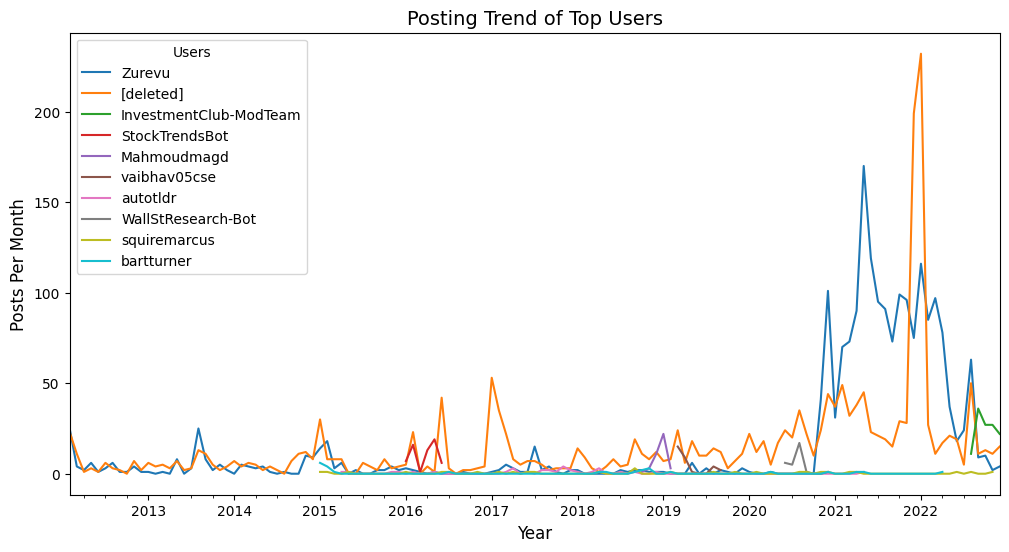

In [46]:
user_activity_sorted = user_activity.sort_values(by="total_posts", ascending=False).head(10)

plt.figure(figsize=(12, 6))

for user in user_activity_sorted.index:
    user_data = new_df[new_df['author'] == user]
    user_data['created_utc'] = pd.to_datetime(user_data['created_utc'])
    user_data.set_index('created_utc', inplace=True)

    # Plot post count per month
    user_data.resample('M').size().plot(label=user)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Posts Per Month", fontsize=12)
plt.title("Posting Trend of Top Users", fontsize=14)
plt.legend(title="Users")
plt.show()

#Topic Modelling


In [47]:
# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Custom stopword list
with open("stopwordFile.txt", "r") as f:
    custom_stopwords = set(f.read().splitlines())

# Preprocess Text
def preprocess(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())  # Convert to lowercase and process
    tokens = [token.lemma_ for token in doc if token.lemma_ not in custom_stopwords
              and not token.is_stop and not token.is_punct]
    return " ".join(tokens)

new_df["cleaned_text"] = new_df["text"].fillna("").apply(preprocess)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(custom_stopwords), ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(new_df["cleaned_text"])

# LDA Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation # Importing the correct module
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_tfidf)

# Extracting top words for each topic
words = vectorizer.get_feature_names_out()
topics_info = []
for i, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[-10:][::-1]  # **Get top 10 words**
    top_words = [words[j] for j in top_words_indices]  # **List of top words**

    topic_label = f"Topic {i+1}"
    topic_name = ", ".join(top_words)  # **Use all 10 words to analyze meaning**

    topics_info.append([topic_label, topic_name])

# Convert topics info into DataFrame
topics_df = pd.DataFrame(topics_info, columns=["topic_label", "top_words"])
print("**Automatically Generated Topics:**")
print(topics_df)

**Automatically Generated Topics:**
  topic_label                                          top_words
0     Topic 1  bitcoin, crypto, referral, buy, code, invest, ...
1     Topic 2  stock portfolio, portfolio, guru, stock, post,...
2     Topic 3  buffett, warren, warren buffett, remove, stock...
3     Topic 4  post, thank, quality, penny, penny stock, topi...
4     Topic 5  delete, com, www, https, pitch, reddit, amp, h...
5     Topic 6  beginner, advice, remove, mean, look advice, m...
6     Topic 7  past, gold, musk, reit, elon, elon musk, year,...
7     Topic 8  stock, market, company, buy, investment, like,...
8     Topic 9  cryptocurrencie, cryptocurrencie topic, topic ...
9    Topic 10  stock, fund, buy, invest, amp, investment, por...


###Top 5 Keys words of each Autogenerated topic

In [53]:
words = vectorizer.get_feature_names_out()

# Extract top 5 words for each topic
top_words_per_topic = {}

for i, topic in enumerate(lda.components_):
    top_words = [words[idx] for idx in topic.argsort()[-5:][::-1]]  # Select top 5 words
    topic_name = topic_name_map.get(f"Topic {i+1}", f"Topic {i+1}")  # Get topic name from mapping
    top_words_per_topic[topic_name] = ", ".join(top_words)  # Convert list to string

# Map top words to topics using actual topic names, use 'topic_group' instead of 'topic_name'
new_df["top_5_words"] = new_df["topic_group"].map(top_words_per_topic)

# Display the mapping
print("🔹 Top 5 Words for Each Topic:")
for topic, words in top_words_per_topic.items():
    print(f"{topic}: {words}")

🔹 Top 5 Words for Each Topic:
Cryptocurrency & Investments: bitcoin, crypto, referral, buy, code
Stock Portfolio & Analysis: stock portfolio, portfolio, guru, stock, post
Warren Buffett & Value Investing: buffett, warren, warren buffett, remove, stock
Penny Stocks & Market Trends: post, thank, quality, penny, penny stock
Online Investment Promotions & Spam: delete, com, www, https, pitch
Beginner Investment Advice: beginner, advice, remove, mean, look advice
Gold, REITs & Elon Musk Investments: past, gold, musk, reit, elon
Stock Market & Company Investments: stock, market, company, buy, investment
Cryptocurrency Discussions: cryptocurrencie, cryptocurrencie topic, topic subreddit, subreddit allow, subreddit
Mutual Funds & General Investing: stock, fund, buy, invest, amp


###Manually Assigning Topic Names

In [48]:
# Define custom topic names based on observed words
topic_name_map = {
    "Topic 1": "Cryptocurrency & Investments",
    "Topic 2": "Stock Portfolio & Analysis",
    "Topic 3": "Warren Buffett & Value Investing",
    "Topic 4": "Penny Stocks & Market Trends",
    "Topic 5": "Online Investment Promotions & Spam",
    "Topic 6": "Beginner Investment Advice",
    "Topic 7": "Gold, REITs & Elon Musk Investments",
    "Topic 8": "Stock Market & Company Investments",
    "Topic 9": "Cryptocurrency Discussions",
    "Topic 10": "Mutual Funds & General Investing"
}

# Assigning manual topic names to
topics_df["assigned_topic_name"] = topics_df["topic_label"].map(topic_name_map)
print("\n**Manually Assigned Topic Names:**")
print(topics_df)
# Assigning topics to each document
topic_assignments = lda.transform(X_tfidf)
new_df["topic"] = topic_assignments.argmax(axis=1)
new_df["topic_label"] = new_df["topic"].apply(lambda x: f"Topic {x+1}")
# Dropping Extra "topic_name" Columns Before Merging
existing_topic_columns = [col for col in new_df.columns if "topic_name" in col]
new_df = new_df.drop(columns=existing_topic_columns, errors="ignore")
# Merging assigned topic names to new_df dataset
new_df = new_df.merge(topics_df[["topic_label", "assigned_topic_name"]], on="topic_label", how="left")
new_df = new_df.rename(columns={"assigned_topic_name": "topic_name"})
print("\n **Final Data with Assigned Topic Names:**")
print(new_df[["text", "topic_label", "topic_name"]].head())


**Manually Assigned Topic Names:**
  topic_label                                          top_words  \
0     Topic 1  bitcoin, crypto, referral, buy, code, invest, ...   
1     Topic 2  stock portfolio, portfolio, guru, stock, post,...   
2     Topic 3  buffett, warren, warren buffett, remove, stock...   
3     Topic 4  post, thank, quality, penny, penny stock, topi...   
4     Topic 5  delete, com, www, https, pitch, reddit, amp, h...   
5     Topic 6  beginner, advice, remove, mean, look advice, m...   
6     Topic 7  past, gold, musk, reit, elon, elon musk, year,...   
7     Topic 8  stock, market, company, buy, investment, like,...   
8     Topic 9  cryptocurrencie, cryptocurrencie topic, topic ...   
9    Topic 10  stock, fund, buy, invest, amp, investment, por...   

                   assigned_topic_name  
0         Cryptocurrency & Investments  
1           Stock Portfolio & Analysis  
2     Warren Buffett & Value Investing  
3         Penny Stocks & Market Trends  
4  Online 

###Topic Engagement Bar Plot

In [49]:
# Posts have no parent ID, while comments have a parent ID
new_df['is_comment'] = ~new_df['unique_parent_id'].isna()  # True if it's a comment

# Convert topic_name to string if it's not already
new_df['topic_name'] = new_df['topic_name'].astype(str)

# Group by topic and count posts and comments
topic_counts = new_df.groupby('topic_name').agg(
    num_comments=('is_comment', 'sum')
).reset_index()

# Sort topics alphabetically (if needed)
topic_counts = topic_counts.sort_values(by="topic_name")

# Bar chart for number of comments
fig_comments = go.Figure(go.Bar(
    x=topic_counts['topic_name'],
    y=topic_counts['num_comments'],
    name='Number of Comments',
    marker_color='rgb(26, 118, 255)'  # Bright Blue
))

fig_comments.update_layout(
    title='Number of Comments per Topic',
    xaxis_title='Topic',
    yaxis_title='Number of Comments',
    template='plotly_white',
    xaxis=dict(tickangle=-45)
)

fig_comments.show()

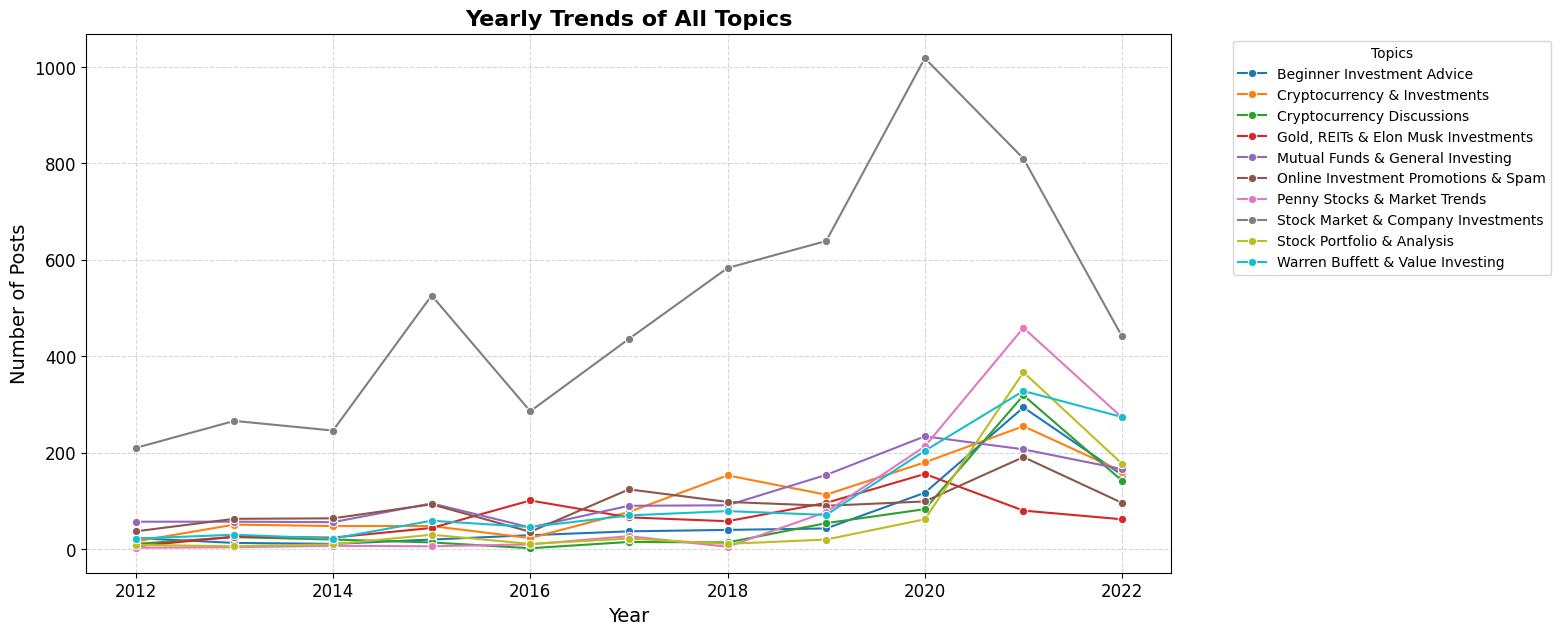

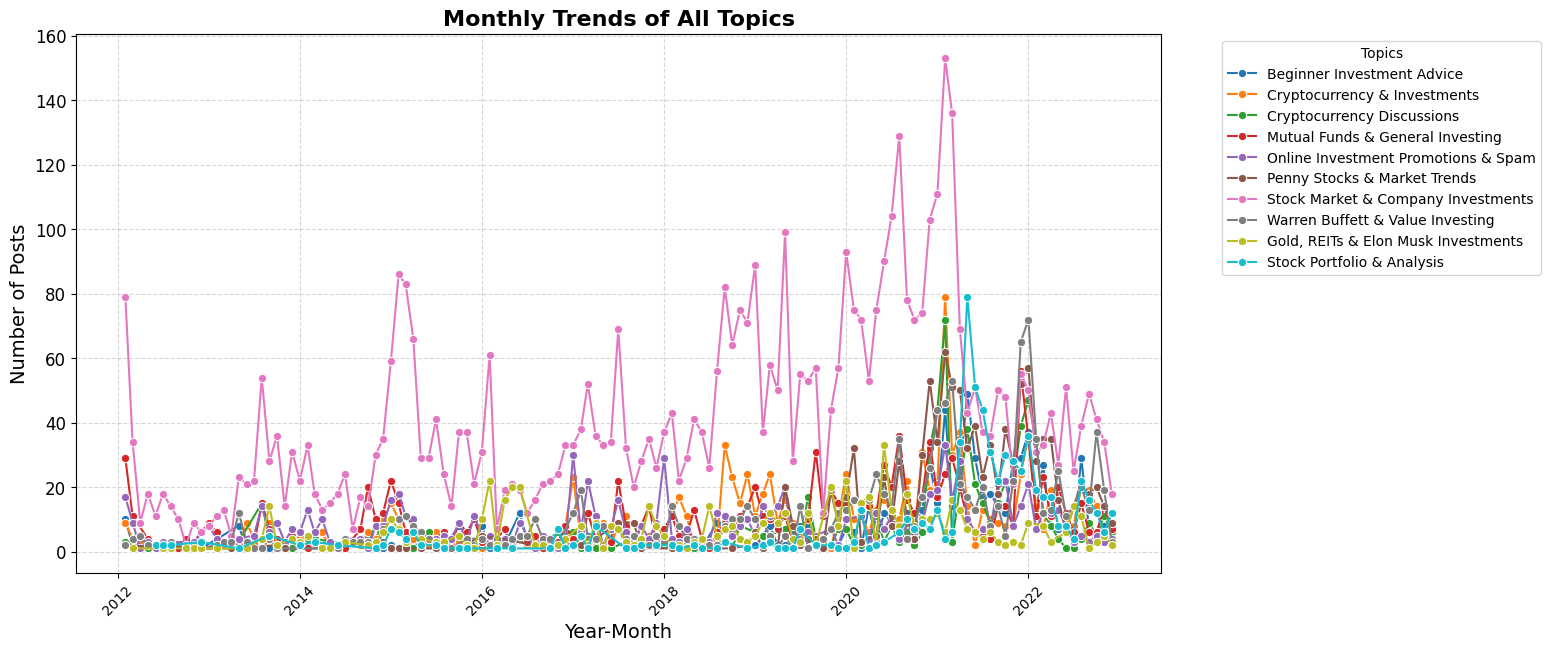

In [50]:
new_df["created_utc"] = pd.to_datetime(new_df["created_utc"], errors="coerce")

# Extract Year & Month-Year for Trend Analysis
new_df["Year"] = new_df["created_utc"].dt.year  # Extract Year
new_df["Year-Month"] = new_df["created_utc"].dt.to_period("M")  # Extract YYYY-MM format

# Count Posts per Topic Over Time (Yearly & Monthly)
topic_trends_yearly = new_df.groupby(["Year", "topic_name"]).size().reset_index(name="Post Count")
topic_trends_monthly = new_df.groupby(["Year-Month", "topic_name"]).size().reset_index(name="Post Count")

# Convert 'Year-Month' to timestamp for better visualization
topic_trends_monthly["Year-Month"] = topic_trends_monthly["Year-Month"].dt.to_timestamp()

# Plot Yearly Topic Trends (Using Topic Names Instead of Numbers)
plt.figure(figsize=(14, 7))
sns.lineplot(data=topic_trends_yearly, x="Year", y="Post Count", hue="topic_name", marker="o", palette="tab10")

plt.title("Yearly Trends of All Topics", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Plot Monthly Topic Trends (Using Topic Names Instead of Numbers)
plt.figure(figsize=(14, 7))
sns.lineplot(data=topic_trends_monthly, x="Year-Month", y="Post Count", hue="topic_name", marker="o", palette="tab10")

plt.title("Monthly Trends of All Topics", fontsize=16, fontweight="bold")
plt.xlabel("Year-Month", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [51]:
topic1_keywords = r"\b(warren|buffett|warren buffett)\b"
topic2_keywords = r"\b(portfolio|stock|guru|stock portfolio)\b"

def classify_topic(text):
    if pd.isna(text):
        return None
    if pd.Series(text).str.contains(topic1_keywords, case=False, na=False).any():
        return "Warren Buffett"
    elif pd.Series(text).str.contains(topic2_keywords, case=False, na=False).any():
        return "Stock Portfolio & Analysis"
    return None

new_df["topic_group"] = new_df["cleaned_text"].apply(classify_topic)

#Community Graph Of Two Chosen Topics

In [52]:
# Function to build a graph for each topic
def build_graph(df, topic_group):
    G = nx.Graph()
    topic_data = df[df["topic_group"] == topic_group]

    for _, row in topic_data.iterrows():
        user = row["author"]
        reply_to = row["unique_parent_id"]

        G.add_node(user)

        if pd.notna(reply_to):
            G.add_node(reply_to)
            G.add_edge(user, reply_to)

    return G

# Function to visualize community graph using Plotly
def plot_community_graph(G, topic_group):
    if G.number_of_nodes() == 0:
        print(f"Skipping {topic_group} - No interactions")
        return

    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G, seed=42)
    node_colors = [partition[node] for node in G.nodes()]

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode="lines", line=dict(width=0.5, color="gray"), hoverinfo="none"))
    node_x, node_y = zip(*[pos[node] for node in G.nodes()])
    node_text = list(G.nodes())

    fig.add_trace(go.Scatter(
        x=node_x, y=node_y, mode="markers",
        marker=dict(size=10, color=node_colors, colorscale="Viridis", showscale=True),
        text=node_text, hoverinfo="text"
    ))

    fig.update_layout(
        title=f"Community Graph for Topic: {topic_group}",
        showlegend=False, hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    fig.show()

# Ensure you're using the correct column name
unique_topics = new_df["topic_group"].dropna().unique()

# Loop through each topic to create community graphs
for topic_group in unique_topics:
    G = build_graph(new_df, topic_group)
    plot_community_graph(G, topic_group)

In [54]:
# Ensure 'created_utc' is in datetime format
new_df["created_utc"] = pd.to_datetime(new_df["created_utc"], errors="coerce")

# Define Two Topics with Relevant Keywords
topic1_keywords = r"\b(warren|buffett|warren buffett)\b"
topic2_keywords = r"\b(portfolio|stock|guru|stock portfolio)\b"
new_df["year"] = new_df["created_utc"].dt.year

# Filter Comments for Each Topic
rel_comments_topic1 = new_df["cleaned_text"].str.contains(topic1_keywords, case=False, na=False)
rel_comments_topic2 = new_df["cleaned_text"].str.contains(topic2_keywords, case=False, na=False)

# Count occurrences by year for both topics
com_count_topic1 = new_df[rel_comments_topic1].groupby("year").size().reset_index(name="count_topic1")
com_count_topic2 = new_df[rel_comments_topic2].groupby("year").size().reset_index(name="count_topic2")

# Merge Both Topic Counts for Comparison
com_count = pd.merge(com_count_topic1, com_count_topic2, on="year", how="outer").fillna(0)
com_count_melted = com_count.melt(id_vars=["year"],
                                   value_vars=["count_topic1", "count_topic2"],
                                   var_name="Topic",
                                   value_name="Mentions")

# Rename Topics for Better Labels
topic_labels = {
    "count_topic1": "Warren Buffett Mentions",
    "count_topic2": "Stock Portfolio & Analysis Mentions"
}
com_count_melted["Topic"] = com_count_melted["Topic"].map(topic_labels)

# Plot occurrences over time for both topics
fig = px.line(
    com_count_melted,
    x="year",
    y="Mentions",
    color="Topic",
    markers=True,
    title="Mentions of Warren Buffett vs Stock Portfolio & Analysis Over Time",
    labels={"year": "Year", "Mentions": "Number of Mentions"},
)
fig.show()

#Community Detection in Super User Discussions

In [55]:
# Defining Topic Keywords
topic1_keywords = r"\b(warren|buffett|warren buffett)\b"
topic2_keywords = r"\b(portfolio|stock|guru|stock portfolio)\b"

# Filter Data for Each Topic
def classify_topic(text):
    if pd.isna(text):
        return None
    if pd.Series(text).str.contains(topic1_keywords, case=False, na=False).any():
        return "Warren Buffett"
    elif pd.Series(text).str.contains(topic2_keywords, case=False, na=False).any():
        return "Stock Portfolio & Analysis"
    return None

new_df["topic_group"] = new_df["cleaned_text"].apply(classify_topic)

# Keep only relevant topics
df_topic1 = new_df[new_df["topic_group"] == "Warren Buffett"]
df_topic2 = new_df[new_df["topic_group"] == "Stock Portfolio & Analysis"]
print(f"Filtered Data: {len(df_topic1)} posts for Warren Buffett, {len(df_topic2)} posts for Stock Portfolio & Analysis")

def build_graph(df):
    G = nx.Graph()
    user_interactions = df["author"].value_counts()

    # Keep only active users with at least 5 interactions
    active_users = user_interactions[user_interactions >= 5].index.tolist()
    df = df[df["author"].isin(active_users)]
    G.add_nodes_from(active_users)

    # Create weighted edges between users
    edge_count = {}
    users_in_topic = df["author"].unique()

    for i in range(len(users_in_topic)):
        for j in range(i + 1, len(users_in_topic)):
            edge = tuple(sorted([users_in_topic[i], users_in_topic[j]]))
            edge_count[edge] = edge_count.get(edge, 0) + 1

    # Keep only top 10,000 edges
    sorted_edges = sorted(edge_count.items(), key=lambda x: x[1], reverse=True)[:10000]
    G.add_edges_from([e[0] for e in sorted_edges])

    return G

G_topic1 = build_graph(df_topic1)
G_topic2 = build_graph(df_topic2)

print(f"Graph Created: {G_topic1.number_of_nodes()} nodes & {G_topic1.number_of_edges()} edges for Warren Buffett")
print(f"Graph Created: {G_topic2.number_of_nodes()} nodes & {G_topic2.number_of_edges()} edges for Stock Portfolio & Analysis")

# Function to Plot Graph
def plot_graph(G, title):
    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G, seed=42, k=0.8)

    # Extract node positions
    node_x, node_y, node_color = [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(partition[node])  # Community ID as color

    # Extract edge positions
    edge_x, edge_y = [], []
    for edge in G.edges():
        if edge[0] in pos and edge[1] in pos:  # Ensure node positions exist
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
    fig = go.Figure()

    # Add edges
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.3, color="gray"),
        hoverinfo="none",
        mode="lines"
    ))

    # Add nodes (colored by community)
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(size=8, color=node_color, opacity=0.8, colorscale="Viridis"),
        text=list(G.nodes()),
        textposition="top center",
        hoverinfo="text"
    ))

    # Set layout
    fig.update_layout(
        title=title,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )

    return fig

# Ploting Both Graphs Separately
fig_topic1 = plot_graph(G_topic1, "Community Graph for Warren Buffett Discussions")
fig_topic2 = plot_graph(G_topic2, "Community Graph for Stock Portfolio & Analysis Discussions")
fig_topic1.show()
fig_topic2.show()


Filtered Data: 554 posts for Warren Buffett, 4181 posts for Stock Portfolio & Analysis
Graph Created: 3 nodes & 3 edges for Warren Buffett
Graph Created: 39 nodes & 741 edges for Stock Portfolio & Analysis


#Rich Club Coefficient

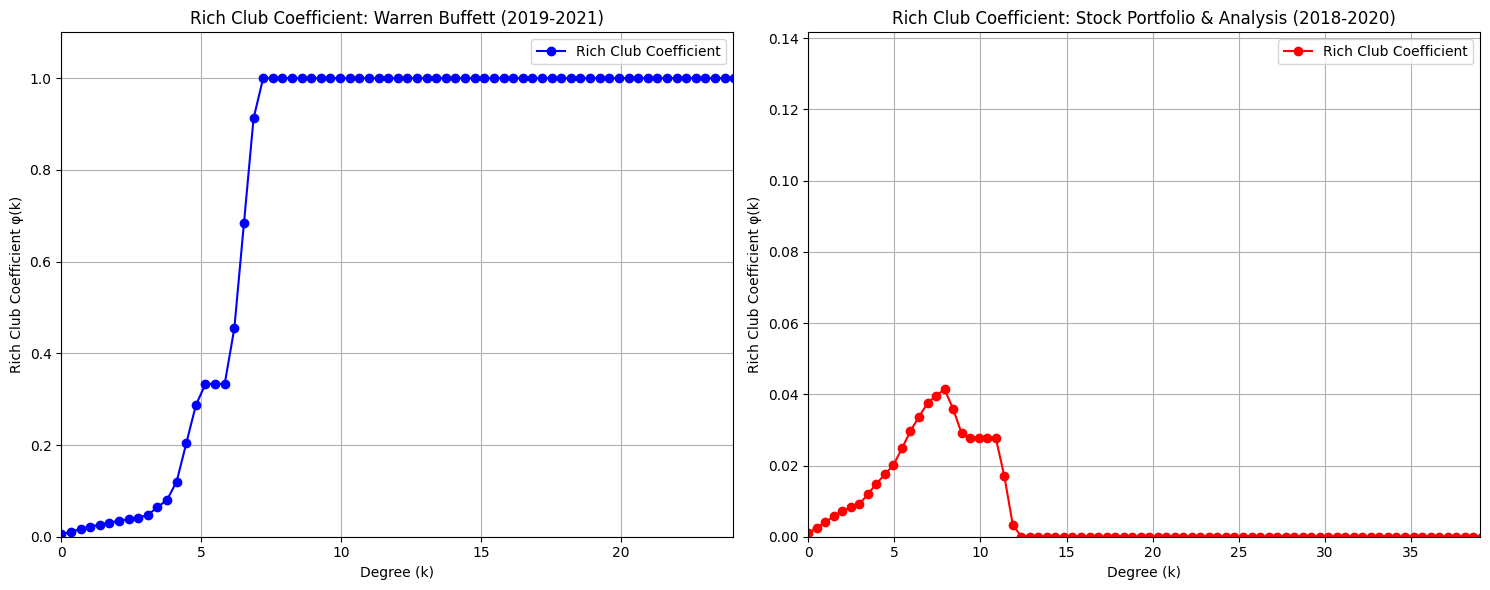

In [56]:
# Function to build a graph
def build_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        user = row["author"]
        reply_to = row["unique_parent_id"]
        G.add_node(user)
        if pd.notna(reply_to):
            G.add_node(reply_to)
            G.add_edge(user, reply_to)
    return G

# Define Two Topics & Their Time Ranges
topic1_keywords = r"\b(warren|buffett|warren buffett)\b"
topic2_keywords = r"\b(portfolio|stock|guru|stock portfolio)\b"

# Filter Mentions for Each Topic
rel_comments_topic1 = new_df["cleaned_text"].str.contains(topic1_keywords, case=False, na=False)
rel_comments_topic2 = new_df["cleaned_text"].str.contains(topic2_keywords, case=False, na=False)
new_df["year"] = new_df["created_utc"].dt.year

# Define Time Periods for Each Topic
time_period_topic1 = [2019, 2020, 2021]
time_period_topic2 = [2017,2018,2019,2020]

# Filter Data for Each Topic and Time Period
filtered_data_topic1 = new_df[(rel_comments_topic1) & (new_df["year"].isin(time_period_topic1))]
filtered_data_topic2 = new_df[(rel_comments_topic2) & (new_df["year"].isin(time_period_topic2))]

G_topic1 = build_graph(filtered_data_topic1)
G_topic2 = build_graph(filtered_data_topic2)

# Compute Rich Club Coefficients
rich_club_topic1 = nx.rich_club_coefficient(G_topic1, normalized=False)
rich_club_topic2 = nx.rich_club_coefficient(G_topic2, normalized=False)

degrees1, coefficients1 = list(rich_club_topic1.keys()), list(rich_club_topic1.values())
degrees2, coefficients2 = list(rich_club_topic2.keys()), list(rich_club_topic2.values())

extended_degrees1 = np.linspace(min(degrees1), max(degrees1) + 20, 100) if degrees1 else []
extended_degrees2 = np.linspace(min(degrees2), max(degrees2) + 20, 100) if degrees2 else []
interpolated_coefficients1 = np.interp(extended_degrees1, degrees1, coefficients1) if degrees1 else []
interpolated_coefficients2 = np.interp(extended_degrees2, degrees2, coefficients2) if degrees2 else []

# Plot Side-by-Side Rich Club Coefficient Graphs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# **Plot for Topic 1: Warren Buffett**
axes[0].plot(extended_degrees1, interpolated_coefficients1, marker="o", linestyle="-", color="b", label="Rich Club Coefficient")
axes[0].set_xlim([0, max(degrees1) + 10]) if degrees1 else None
axes[0].set_ylim([0, max(coefficients1) + 0.1]) if coefficients1 else None
axes[0].set_xlabel("Degree (k)")
axes[0].set_ylabel("Rich Club Coefficient φ(k)")
axes[0].set_title("Rich Club Coefficient: Warren Buffett (2019-2021)")
axes[0].legend()
axes[0].grid(True)

# **Plot for Topic 2: Bitcoin & Crypto**
axes[1].plot(extended_degrees2, interpolated_coefficients2, marker="o", linestyle="-", color="r", label="Rich Club Coefficient")
axes[1].set_xlim([0, max(degrees2) + 10]) if degrees2 else None
axes[1].set_ylim([0, max(coefficients2) + 0.1]) if coefficients2 else None
axes[1].set_xlabel("Degree (k)")
axes[1].set_ylabel("Rich Club Coefficient φ(k)")
axes[1].set_title("Rich Club Coefficient: Stock Portfolio & Analysis (2018-2020)")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()


#Sensitivity Analysis

Rows matching the topic (warren, buffett, warren buffett): 554
Graph contains 583 nodes and 398 edges for ['warren', 'buffett', 'warren buffett']
Rows matching the topic (portfolio, stock, guru, stock portfolio): 4407
Graph contains 3497 nodes and 2829 edges for ['portfolio', 'stock', 'guru', 'stock portfolio']


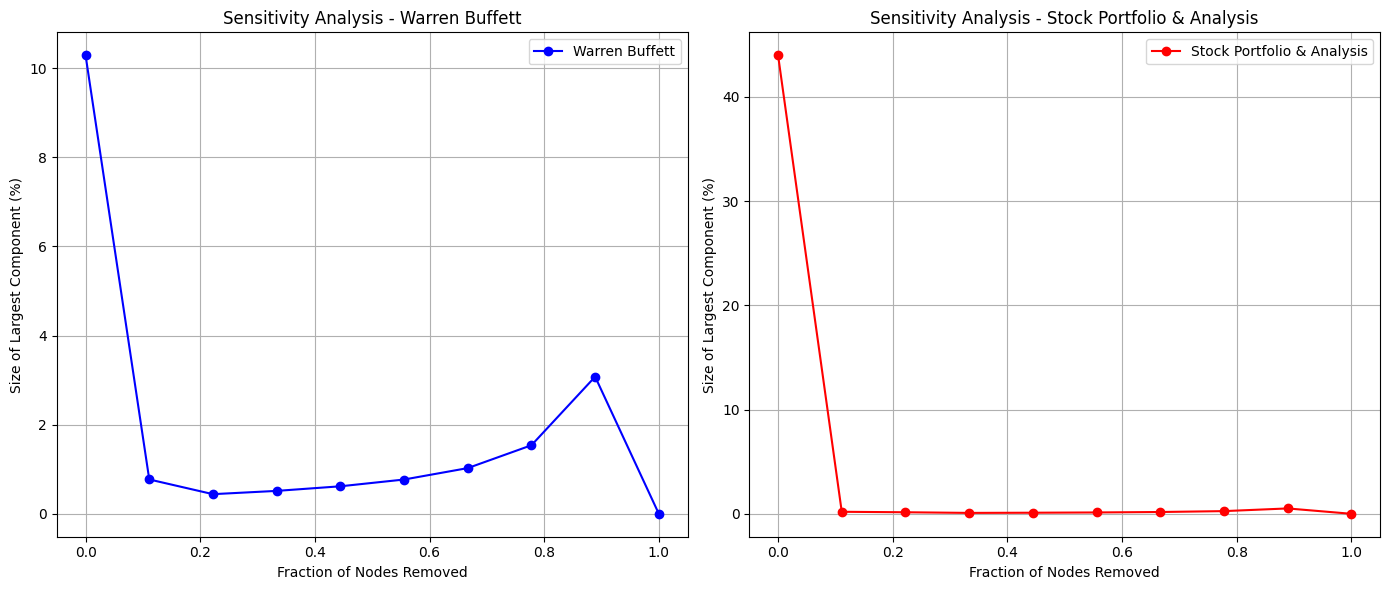

In [57]:
# Function to compute the size of the largest connected component
def largest_component_size(G):
    if len(G.nodes()) == 0:
        return 0
    largest_component = max(nx.connected_components(G), key=len)
    return len(largest_component) / len(G.nodes()) * 100  # Return as percentage

# Sensitivity analysis function for a specific topic
def sensitivity_analysis_for_topic(data, topic_keywords, fraction_steps=10):
    G = nx.Graph()

    # Filter data for the topic (match keywords in cleaned text)
    topic_data = data[data["cleaned_text"].apply(lambda x: any(word in x for word in topic_keywords))]
    print(f"Rows matching the topic ({', '.join(topic_keywords)}): {len(topic_data)}")

    # Remove top 5 most active users
    top_users = topic_data["author"].value_counts().head(2).index.tolist()
    filtered_topic_data = topic_data[~topic_data["author"].isin(top_users)]

    # Build the graph for the filtered topic data (after removing top 5 users)
    for _, row in filtered_topic_data.iterrows():
        author = row["author"]
        parent = row["unique_parent_id"]

        if pd.notna(parent) and parent in filtered_topic_data["unique_parent_id"].values:
            G.add_edge(author, parent)

    print(f"Graph contains {len(G.nodes())} nodes and {len(G.edges())} edges for {topic_keywords}")

    if len(G.nodes()) == 0:
        return pd.DataFrame(columns=["Fraction of Nodes Removed", "Largest Component Size (%)"])

    # Sensitivity analysis: Remove nodes and measure largest component
    node_count = len(G.nodes())
    fractions = np.linspace(0, 1, fraction_steps)
    largest_component_sizes = []

    sorted_nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)

    for fraction in fractions:
        nodes_to_remove = int(fraction * node_count)
        nodes_removed = sorted_nodes[:nodes_to_remove]
        G.remove_nodes_from(nodes_removed)
        largest_size = largest_component_size(G)
        largest_component_sizes.append(largest_size)
    result_df = pd.DataFrame({
        "Fraction of Nodes Removed": fractions,
        "Largest Component Size (%)": largest_component_sizes
    })

    return result_df

# Perform sensitivity analysis on both topics
result_topic1 = sensitivity_analysis_for_topic(new_df, ["warren", "buffett", "warren buffett"])
result_topic2 = sensitivity_analysis_for_topic(new_df, ["portfolio","stock", "guru", "stock portfolio"])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# **Plot for Warren Buffett**
axes[0].plot(result_topic1["Fraction of Nodes Removed"], result_topic1["Largest Component Size (%)"],
             label="Warren Buffett", color="blue", marker="o", linestyle="-")
axes[0].set_xlabel("Fraction of Nodes Removed")
axes[0].set_ylabel("Size of Largest Component (%)")
axes[0].set_title("Sensitivity Analysis - Warren Buffett")
axes[0].legend()
axes[0].grid(True)

# **Plot for Stock Portfolio & Analysis**
axes[1].plot(result_topic2["Fraction of Nodes Removed"], result_topic2["Largest Component Size (%)"],
             label="Stock Portfolio & Analysis", color="red", marker="o", linestyle="-")
axes[1].set_xlabel("Fraction of Nodes Removed")
axes[1].set_ylabel("Size of Largest Component (%)")
axes[1].set_title("Sensitivity Analysis - Stock Portfolio & Analysis")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()


#Z-Score Graph

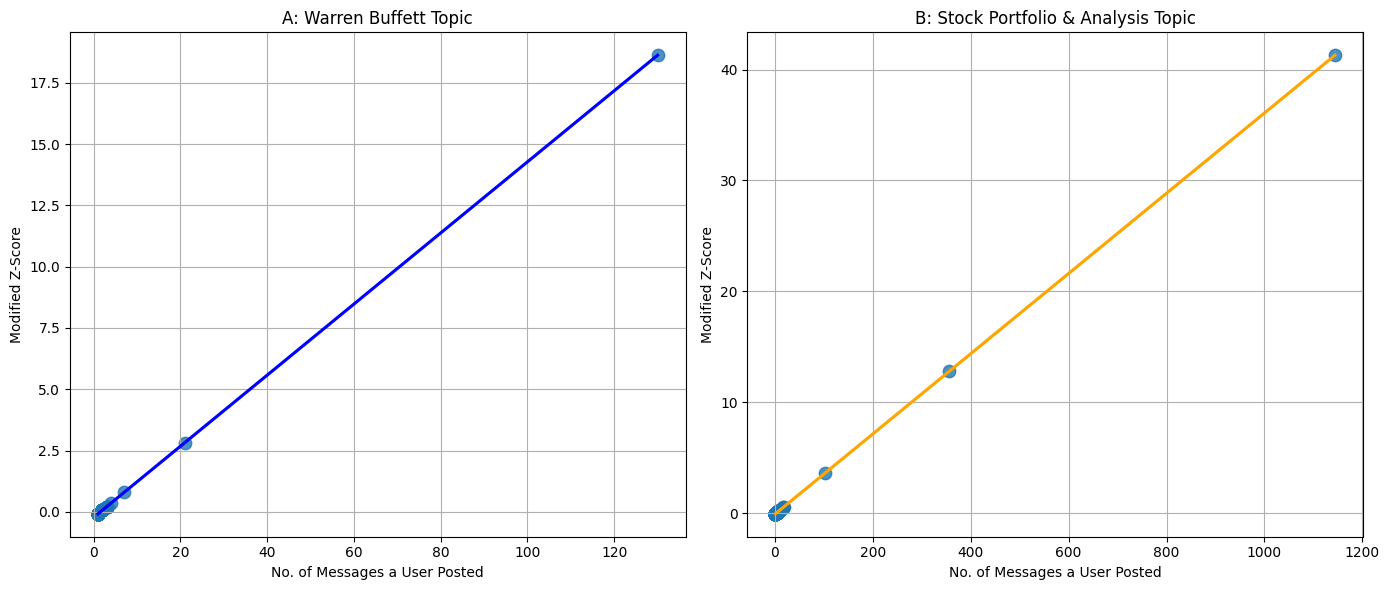

In [58]:
#Define Keywords for Classification
topic1_keywords = r"\b(warren|buffett|warren buffett)\b"
topic2_keywords = r"\b(portfolio|stock|guru|stock portfolio)\b"

#Classifying Posts/Comments into Topics
def classify_topic(text):
    if pd.isna(text):
        return None
    if pd.Series(text).str.contains(topic1_keywords, case=False, na=False).any():
        return "Warren Buffett"
    elif pd.Series(text).str.contains(topic2_keywords, case=False, na=False).any():
        return "Stock Portfolio & Analysis"
    return None

#Applying Classification to the Dataset
new_df["topic_group"] = new_df["cleaned_text"].apply(classify_topic)

#Filtering Data for Each Topic
df_topic1 = new_df[new_df["topic_group"] == "Warren Buffett"]
df_topic2 = new_df[new_df["topic_group"] == "Stock Portfolio & Analysis"]

#Counting Posts/Comments Per User for Each Topic
user_activity_topic1 = df_topic1.groupby("author").size().reset_index(name="post_count")
user_activity_topic2 = df_topic2.groupby("author").size().reset_index(name="post_count")

user_activity_topic1["post_count"].fillna(0, inplace=True)
user_activity_topic2["post_count"].fillna(0, inplace=True)
if user_activity_topic1["post_count"].std() == 0 or user_activity_topic2["post_count"].std() == 0:
    raise ValueError("Standard deviation is zero, meaning all values might be identical.")

#Computing Z-Score for User Activity
user_activity_topic1["z_score"] = stats.zscore(user_activity_topic1["post_count"])
user_activity_topic2["z_score"] = stats.zscore(user_activity_topic2["post_count"])
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Warren Buffett Topic
sns.regplot(
    x=user_activity_topic1["post_count"], y=user_activity_topic1["z_score"],
    ax=axes[0], scatter_kws={"s": 80}, line_kws={"color": "blue"}
)

# Titles & Labels for Warren Buffett Topic
axes[0].set_title("A: Warren Buffett Topic")
axes[0].set_xlabel("No. of Messages a User Posted")
axes[0].set_ylabel("Modified Z-Score")
axes[0].grid(True)

# Plot for Stock Portfolio & Analysis Topic
sns.regplot(
    x=user_activity_topic2["post_count"], y=user_activity_topic2["z_score"],
    ax=axes[1], scatter_kws={"s": 80}, line_kws={"color": "orange"}
)

# Titles & Labels for Stock Portfolio & Analysis Topic
axes[1].set_title("B: Stock Portfolio & Analysis Topic")
axes[1].set_xlabel("No. of Messages a User Posted")
axes[1].set_ylabel("Modified Z-Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()


#Sentiment Score Analysis

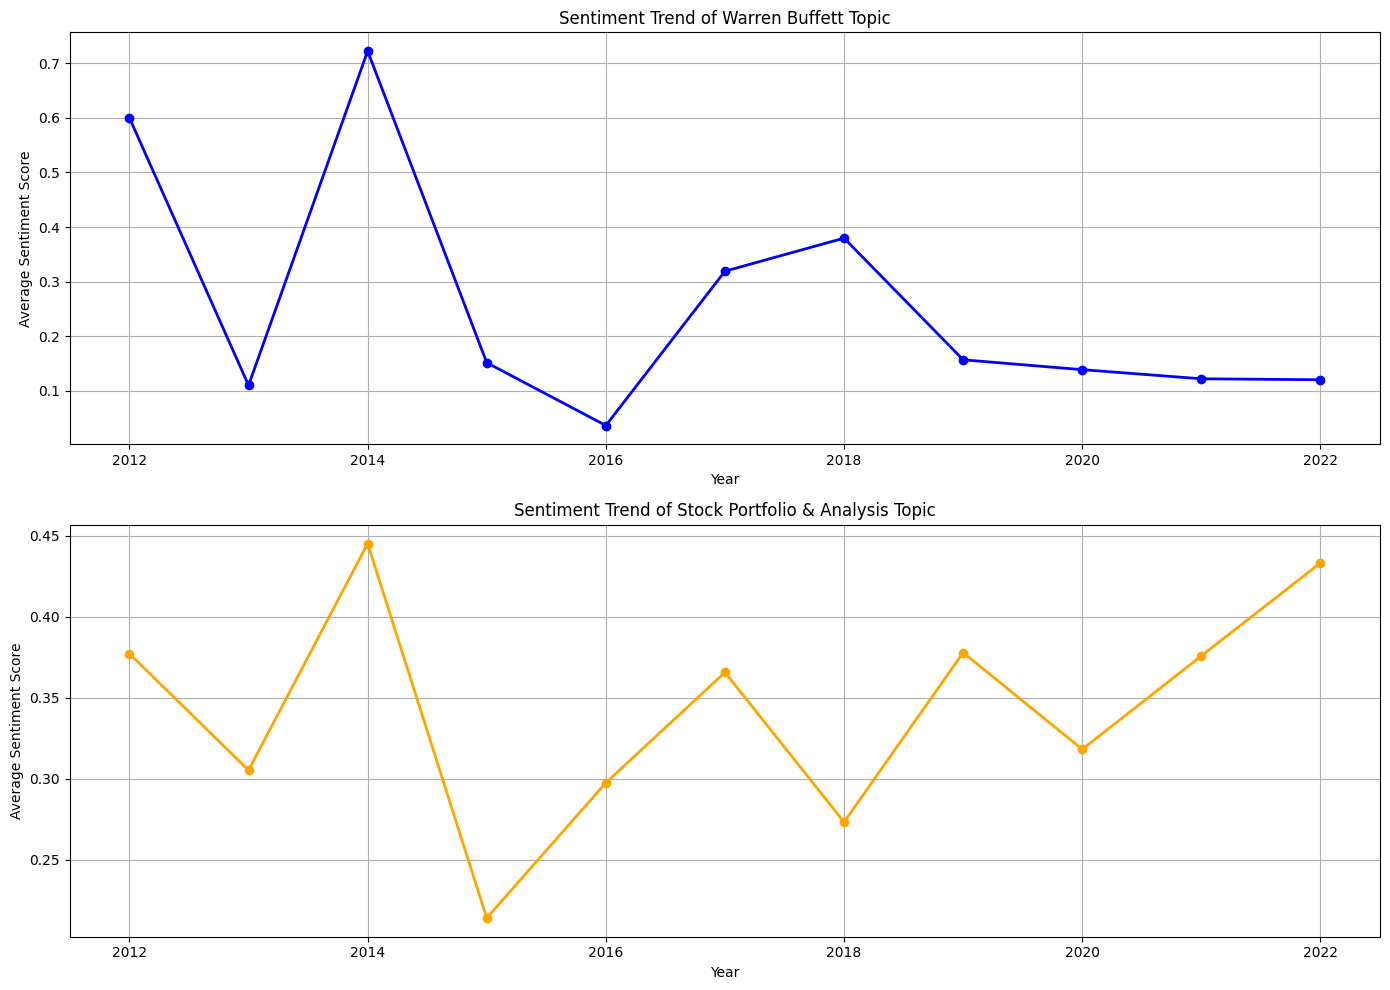

In [59]:
df_topic1["year"] = df_topic1["created_utc"].dt.year
df_topic2["year"] = df_topic2["created_utc"].dt.year

# Computing average sentiment per year
yearly_sentiment_topic1 = df_topic1.groupby("year")["sentiment_score"].mean().reset_index()
yearly_sentiment_topic2 = df_topic2.groupby("year")["sentiment_score"].mean().reset_index()
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Warren Buffett Topic Sentiment Trend
axes[0].plot(yearly_sentiment_topic1["year"], yearly_sentiment_topic1["sentiment_score"],
             marker='o', linestyle='-', color='blue', linewidth=2)
axes[0].set_title("Sentiment Trend of Warren Buffett Topic")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Average Sentiment Score")
axes[0].grid(True)

# Stock Portfolio & Analysis Sentiment Trend
axes[1].plot(yearly_sentiment_topic2["year"], yearly_sentiment_topic2["sentiment_score"],
             marker='o', linestyle='-', color='orange', linewidth=2)
axes[1].set_title("Sentiment Trend of Stock Portfolio & Analysis Topic")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Average Sentiment Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()


#Future Super User Predictions



In [60]:
import pandas as pd

# Ensure timestamps are in datetime format
new_df["year"] = new_df["created_utc"].dt.year

# Aggregate user activity stats
user_stats = new_df.groupby("author").agg(
    post_count=("author", "count"),  # Total Posts/Comments
    upvote_score=("score", "sum"),  # Total Upvotes-Downvotes score
    unique_topics=("topic_group", "nunique"),  # Number of Topics User is Active In
    avg_sentiment=("sentiment_score", "mean"),  # Average Sentiment
    reply_count=("unique_parent_id", "count"),  # Number of Replies Received
    first_activity=("year", "min"),  # First Year of Activity
).reset_index()

user_stats["engagement_score"] = (
    user_stats["post_count"].rank(method="max") * 0.3 +
    user_stats["upvote_score"].rank(method="max") * 0.3 +
    user_stats["reply_count"].rank(method="max") * 0.2 +
    user_stats["unique_topics"].rank(method="max") * 0.2
)

# Sort users by engagement score and select top 5
top_users = user_stats.sort_values(by="engagement_score", ascending=False).head(5)

# Create an interactive table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Author", "Post Count", "Upvote Score", "Reply Count", "Unique Topics", "Avg Sentiment"],
                fill_color="darkblue", align="center", font=dict(color="white", size=14)),
    cells=dict(values=[top_users["author"], top_users["post_count"], top_users["upvote_score"],
                       top_users["reply_count"], top_users["unique_topics"], top_users["avg_sentiment"]],
               fill_color="lightgray", align="center", font=dict(color="black", size=12)))
])

fig.update_layout(title="Top 5 Super Users (Based on Engagement Score)")
fig.show()


In [61]:
# Ensure timestamps are correct
new_df["year"] = new_df["created_utc"].dt.year

# Step 1: Create Features for User Engagement
user_stats = new_df.groupby("author").agg(
    post_count=("author", "count"),
    karma_score=("score", "sum"),
    unique_topics=("topic_group", "nunique"),
    avg_sentiment=("sentiment_score", "mean"),
    reply_count=("unique_parent_id", "count"),
    first_activity=("year", "min"),
).reset_index()

# Define Past Super Users (Before 2020)
past_users = user_stats[user_stats["first_activity"] < 2020]
threshold = past_users["post_count"].quantile(0.95)  # Define top 5% as super users
past_users["is_super_user"] = (past_users["post_count"] >= threshold).astype(int)

# Train Machine Learning Model
X = past_users[["post_count", "karma_score", "reply_count", "unique_topics", "avg_sentiment"]]
y = past_users["is_super_user"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict Future Super Users (2020-2023)
recent_users = user_stats[user_stats["first_activity"] >= 2020]
X_recent = recent_users[["post_count", "karma_score", "reply_count", "unique_topics", "avg_sentiment"]]

recent_users["predicted_super_user"] = model.predict(X_recent)

# Display the top 10 predicted super users in an interactive table
predicted_users = recent_users[(recent_users["predicted_super_user"] == 1) & (recent_users["post_count"] > 10)]

# Create an interactive table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Author", "Post Count", "Upvote Score", "Reply Count", "Unique Topics", "Avg Sentiment"],
                fill_color="darkblue", align="center", font=dict(color="white", size=14)),
    cells=dict(values=[predicted_users["author"], predicted_users["post_count"], predicted_users["karma_score"],
                       predicted_users["reply_count"], predicted_users["unique_topics"], predicted_users["avg_sentiment"]],
               fill_color="lightgray", align="center", font=dict(color="black", size=12)))
])

fig.update_layout(title="Predicted Future Super Users (2020-2023)")
fig.show()